```
inputs: [QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX]
outputs: [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]

```


In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.utils import *
from cbrain.normalization import *
%matplotlib inline

In [3]:
from cbrain.losses import *
from cbrain.layers import *
from cbrain.models import fc_model

In [2]:
CAMDIR = '/scratch/05488/tg847872/revision_debug/'

In [3]:
cam_ds = xr.open_mfdataset(CAMDIR+ 'debug.cam2.h1.*.nc', decode_times=False, concat_dim='time')
cam_ds

<xarray.Dataset>
Dimensions:       (crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 4)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon           (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 ... 38.27 24.61 14.36
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 ... 900.0 900.0 900.2
  * time          (time) float64 0.0 0.02083 0.04167 0.0625
Dimensions without coordina

## why did we crash?

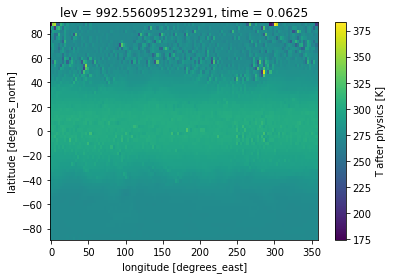

In [50]:
cam_ds.TAP.isel(time=-1, lev=-1).plot()

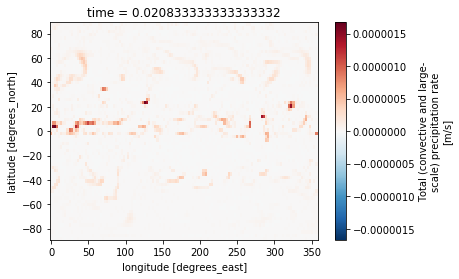

In [51]:
cam_ds.PRECT.isel(time=1).plot()

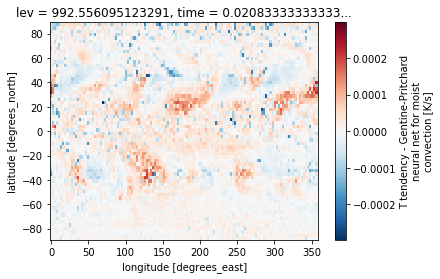

In [52]:
cam_ds.NNDT.isel(time=1, lev=-1).plot()

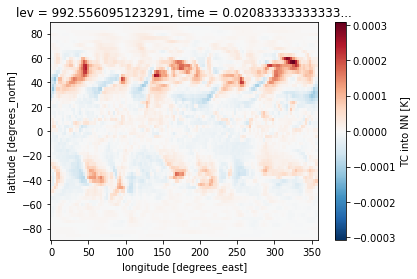

In [53]:
cam_ds.NNT_adia.isel(time=1, lev=-1).plot()

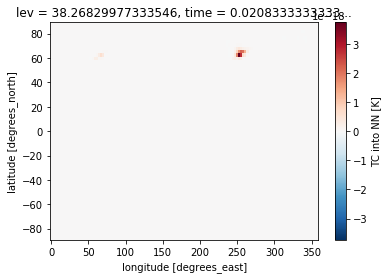

In [60]:
cam_ds.NNQI_adi.isel(time=1, lev=4).plot()

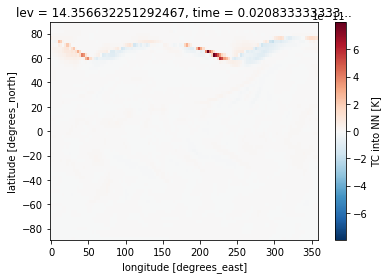

In [55]:
cam_ds.NNQ_adia.isel(time=1, lev=2).plot()

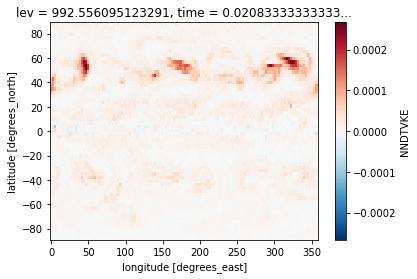

In [24]:
(cam_ds.NNDTVKE / 30 / 60).isel(time=1, lev=-1).plot()

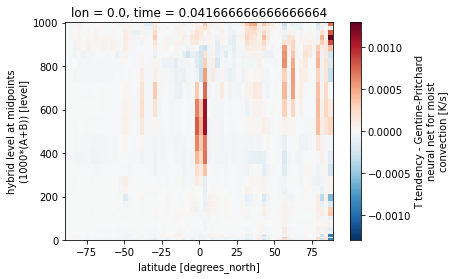

In [28]:
cam_ds.NNDT.isel(time=2, lon=0).plot()

## Check the neural network

In [4]:
inputs = ['QBP', 'QCBP', 'QIBP', 'TBP', 'VBP', 'Qdt_adiabatic', 'QCdt_adiabatic', 'QIdt_adiabatic', 
          'Tdt_adiabatic', 'Vdt_adiabatic', 'PS', 'SOLIN', 'SHFLX', 'LHFLX']
outputs= ['PHQ', 'PHCLDLIQ', 'PHCLDICE', 'TPHYSTND', 'QRL', 'QRS', 'DTVKE', 'FSNT', 'FSNS', 'FLNT', 'FLNS', 
          'PRECT', 'PRECTEND', 'PRECST', 'PRECSTEN']

In [38]:
scale_dict = load_pickle('../../nn_config/scale_dicts/001_toms_scaling.pkl')

In [6]:
input_transform = InputNormalizer(
    xr.open_dataset('/home1/05488/tg847872/saved_models/001_norm.nc'),
    inputs,
    'mean', 'std_by_var'
)

In [39]:
output_transform = DictNormalizer(xr.open_dataset('/home1/05488/tg847872/saved_models/001_norm.nc'), outputs, scale_dict)

In [7]:
input_transform.sub.shape

(304,)

In [8]:
#tf.enable_eager_execution()

In [10]:
model = fc_model(304, 218, [256,256,256,256,256,256,256], 'LeakyReLU')

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
model.load_weights('/home1/05488/tg847872/saved_models/003_8col_weak/weights.h5')

In [12]:
cam_ds.NN

AttributeError: 'Dataset' object has no attribute 'NN'

In [17]:
in_vec = np.concatenate([
    cam_ds.NNQBP.isel(time=1, lat=0, lon=0).values,
    cam_ds.NNQCBP.isel(time=1, lat=0, lon=0).values,
    cam_ds.NNQIBP.isel(time=1, lat=0, lon=0).values,
    cam_ds.NNTBP.isel(time=1, lat=0, lon=0).values,
    cam_ds.NNVBP.isel(time=1, lat=0, lon=0).values,
    cam_ds.NNQ_adia.isel(time=1, lat=0, lon=0).values,
    cam_ds.NNQC_adi.isel(time=1, lat=0, lon=0).values,
    cam_ds.NNQI_adi.isel(time=1, lat=0, lon=0).values,
    cam_ds.NNT_adia.isel(time=1, lat=0, lon=0).values,
    cam_ds.NNV_adia.isel(time=1, lat=0, lon=0).values,
    cam_ds.NNPS.isel(time=1, lat=0, lon=0).values[None],
    cam_ds.NNSOLIN.isel(time=1, lat=0, lon=0).values[None],
    cam_ds.NNSHF.isel(time=1, lat=0, lon=0).values[None],
    cam_ds.NNLHF.isel(time=1, lat=0, lon=0).values[None],
])[None, :]

In [18]:
in_vec.shape

(1, 304)

In [24]:
in_vec_trans = input_transform.transform(in_vec).astype(np.float32)

In [26]:
layers = model.layers; layers

In [40]:
outp = model(in_vec_trans)

In [42]:
outp_scale = output_transform.inverse_transform(outp.numpy())

In [43]:
outp_scale

array([[-6.70365846e-11,  2.99244213e-10,  7.14735271e-10,
        -4.97966009e-11, -1.52515819e-10, -1.81600721e-10,
         1.79020215e-10,  2.57704309e-11,  6.72772810e-11,
        -1.00508976e-10, -1.10272075e-13, -8.96770921e-11,
         4.24795754e-11, -4.22151099e-11,  8.94418151e-11,
        -2.16942353e-10, -1.07242840e-10,  6.10483053e-11,
        -2.76133404e-11, -1.59719113e-11, -5.14238485e-10,
         8.33464686e-11,  1.24646016e-09,  1.06529330e-09,
         8.19738777e-10,  8.36276104e-10,  4.15957491e-10,
         9.53280566e-10,  4.39223724e-09,  5.76273207e-09,
        -5.50380741e-10,  8.07007239e-10, -3.99831529e-10,
        -7.06867273e-11, -6.73779019e-11,  5.78619722e-11,
        -1.64847191e-10, -9.69287931e-12,  9.75331621e-12,
         3.77988509e-11,  1.25437813e-10, -1.48651702e-10,
         3.63814742e-11, -5.60139921e-11, -9.17983328e-11,
        -2.32655891e-11, -5.34813339e-11,  1.04884663e-10,
         1.28377406e-10,  8.48833503e-11,  1.92890509e-1

In [44]:
a = np.array("""-6.707290615359099E-011  2.992220269741707E-010
  7.147294739430913E-010 -4.980172588945511E-011 -1.525016918257820E-010
 -1.815995626327645E-010  1.790183874408991E-010  2.576684185335129E-011
  6.727380836191728E-011 -1.005076438989125E-010 -1.104144085139271E-013
 -8.967225532891214E-011  4.247488055411539E-011 -4.221682312785091E-011
  8.944159509212569E-011 -2.169426245233285E-010 -1.072390077695847E-010
  6.105456341320913E-011 -2.761664256617219E-011 -1.595618015371752E-011
 -5.142293254253205E-010  8.333337693262898E-011  1.246378958178744E-009
  1.065193647721009E-009  8.198450907917733E-010  8.363210863073671E-010
  4.158738981723587E-010  9.533537834149493E-010  4.392486354421883E-009
  5.762967538165273E-009 -5.503849274027930E-010  8.070081166512547E-010
 -3.998379047326615E-010 -7.068259387409014E-011 -6.737391994365314E-011
  5.787102324828249E-011 -1.648452185205006E-010 -9.699201669826588E-012
  9.751295030127152E-012  3.780282878329759E-011  1.254393788156788E-010
 -1.486509067243945E-010  3.638183541162152E-011 -5.601379853091157E-011
 -9.179707099750061E-011 -2.326422131890909E-011 -5.348023129811820E-011
  1.048840256805763E-010  1.283738894082569E-010  8.488770954490318E-011
  1.928932191129001E-010  1.988757240246825E-011  3.402242043782369E-010
  7.320879853351953E-010  1.751340487337874E-009  1.017847714724497E-010
 -1.889794431838514E-010  4.361880597709919E-011 -1.411012800109166E-010
  1.863727974244665E-010  7.091193785886249E-011  6.581137426556077E-010
 -1.721289930914193E-010  2.074114289424016E-010 -2.257172391579689E-010
 -2.502371790361448E-011 -1.786161891790795E-010 -1.964565291883691E-010
  4.059428132805681E-011 -2.198515877356154E-010 -1.389908811501560E-010
  3.653697311106680E-011 -5.157850502962352E-011 -3.035956781531974E-011
 -7.946875594209375E-011 -1.407410871841048E-010  2.490070676142603E-010
  4.605072585296800E-011 -1.125507398670080E-010 -9.242697197019639E-011
 -1.670322224076949E-010  8.706931849500394E-011  4.158765961380099E-011
  7.702928225052835E-010  8.047464566005839E-010 -7.158162724375640E-012
 -4.459352246646704E-011  4.129447007570143E-011  3.414561773053639E-011
 -1.310760120413052E-010 -1.568698027719090E-006 -3.310414229352987E-006
 -8.575465093834824E-007  6.779127848552661E-007 -2.157487740025543E-006
 -2.652968823138949E-007 -5.750031726572715E-007 -9.649089785999452E-007
 -1.110195882099346E-006 -7.499865933781821E-007 -1.624216939967253E-007
 -5.311441481230746E-007  4.873569149018107E-007 -6.925742439995050E-007
 -1.133992627219794E-006 -2.810469021871522E-006 -5.592380685669543E-006
 -7.535519312371742E-006 -7.688044235217394E-006 -6.094070342033875E-006
 -5.001581498831052E-006 -5.544601697005826E-006 -5.311553196177395E-006
 -5.633943923821556E-006 -1.305432709030147E-005 -1.745616431094921E-005
 -3.929745618729709E-006 -1.651658257294793E-006 -7.317473021029151E-007
 -1.329414987704786E-006 -6.041177789825882E-005 -3.935513823494503E-005
 -6.668820537405843E-006 -3.176235740529415E-005 -1.763998681494991E-005
 -1.318063714627394E-005 -1.002667125006725E-005 -8.589155942739286E-006
 -7.493846227037795E-006 -5.810335157013483E-006 -4.006914963705429E-006
 -3.615896812579356E-006 -3.191521469441304E-006 -2.741321573402627E-006
 -3.943535132883148E-006 -5.897127787654726E-006 -1.039259736501348E-005
 -1.581678943290809E-005 -1.753987681334121E-005 -1.669862440531271E-005
 -1.522896202964018E-005 -1.597691717750587E-005 -1.622912280730597E-005
 -1.654477820469184E-005 -3.820335084822214E-005 -3.900468480300913E-005
 -1.287806288451789E-005 -1.075131663597520E-005 -1.164504852299180E-005
 -1.500072129875325E-005  5.770584263945308E-005  3.620505887061199E-005
  2.549588526684244E-005  1.924410356037605E-005  1.537197158622693E-005
  1.243452330765183E-005  9.733084332217391E-006  7.710924023102314E-006
  6.178355846148757E-006  4.927056859268428E-006  4.010579425163261E-006
  3.515959493991395E-006  3.281362404329568E-006  3.141208883802928E-006
  3.452127724675626E-006  3.031907527180371E-006  4.588035652296985E-006
  7.837681602918485E-006  9.871659030238648E-006  1.073068718551821E-005
  9.733916589230640E-006  9.885620179817345E-006  1.123448679550862E-005
  1.124578590538806E-005  1.431638075137344E-005  1.420504757304456E-005
  1.029731693905587E-005  9.176017712177477E-006  8.670903419261224E-006
  7.259495900010062E-006 -4.219156541587099E-003  3.945611048897580E-004
 -5.371587850537098E-004 -2.468102394887706E-004  8.451628988536135E-004
 -7.738309383558390E-005 -8.580189007611663E-005 -7.054305970360800E-004
  4.978794959090862E-004 -7.011224215809533E-005  4.362020963868919E-004
  1.297100207071601E-004  4.131722574927347E-004  2.010245533665466E-004
  7.671116697159422E-005  2.923639282818982E-004 -1.952620734434873E-004
 -2.393882741177598E-006 -1.023524526426688E-005  3.623999588877718E-005
  1.657925405904501E-004  6.528984861363835E-005 -2.052636827037711E-004
 -7.079279085423187E-006 -1.466148789834421E-004  6.183401414740583E-005
  7.616917907204729E-004  1.389965437236221E-003 -3.818799547956206E-004
 -1.702953218409887E-003   382.052469852410        292.446894608828     
   231.129675273872        88.5005449865017       1.007659139275526E-010
  1.084775814101992E-007  2.046500997155875E-010  5.802704797775307E-008
""".split()).astype(float)

In [48]:
rel = (a-outp_scale[0])/a

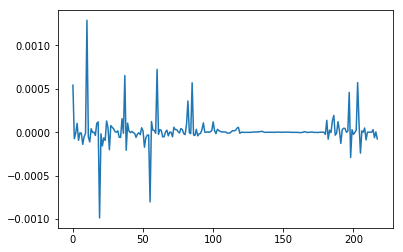

In [49]:
plt.plot(rel)

In [28]:
x1 = layers[2](layers[1](layers[0](in_vec_trans)))

In [32]:
np.isclose(np.array("""-4.749545837947178E-003  3.912088625065702E-002
  0.153073397015550      -1.538649720234919E-002 -5.911339204312283E-002
 -8.084894248213859E-002  7.934334816019817E-002  9.357818679722962E-003
  2.874297680833926E-002 -5.051933299234401E-002 -6.529165030544348E-005
 -6.238243237304730E-002  3.476235545541995E-002 -4.064766602901182E-002
  0.101312373034348      -0.289094921185669      -0.168120737260533     
  0.112605434540082      -5.992181777408856E-002 -3.463513884504554E-002
  -1.02445846092816       0.140098156631466        1.55731934877039     
  0.770520500883400       0.556377704786711       0.525564158709512     
  0.238308053520147       0.488879248122916        1.96871941203006     
   2.18822413129852      -3.897368685991909E-002  0.105509855187218     
 -8.563316410522270E-002 -2.183774785862891E-002 -2.611578203119858E-002
  2.576443996973998E-002 -7.306160977421405E-002 -3.522487198115765E-003
  4.166275906283934E-003  1.900127812444563E-002  7.417640656139812E-002
 -0.103412199257320       2.977567631033240E-002 -5.393182165331611E-002
 -0.103980470057360      -3.100159889470111E-002 -8.384202821068587E-002
  0.193441908807740       0.278542070769132       0.184260742734258     
  0.384285921874321       3.343452930886437E-002  0.425101637765498     
  0.529564556039239        1.18852550510981       6.396398304932560E-002
 -0.108290814735865       2.236769753377288E-002 -6.324181946294083E-002
  7.076657122237862E-002  5.021394160961035E-003  8.604310694227946E-002
 -3.686481481169135E-002  6.408081877004257E-002 -8.749353196998810E-002
 -1.114067181741973E-002 -7.916508850110304E-002 -7.134768742927466E-002
  1.734405283682505E-002 -0.110506575807129      -8.218985302590087E-002
  2.541773088963550E-002 -4.221295745410203E-002 -2.923113303919211E-002
 -9.001592869948438E-002 -0.187549743147405       0.390373360040228     
  8.493324177038886E-002 -0.244209443942718      -0.200625774864359     
 -0.332765101157280       0.146378935659475       5.196274099595399E-002
  0.557200479643785       0.546131203915924      -4.498360536086765E-003
 -2.555340834155062E-002  2.117577947813765E-002  1.530412049981478E-002
 -4.977013850653655E-002 -4.462117616302175E-002 -0.173857757975279     
 -7.377554944691000E-002  8.413290849469068E-002 -0.335935943536157     
 -4.744479242361710E-002 -0.102371724849748      -0.140765553361257     
 -0.190538256422006      -0.151428893085077      -3.858093453652855E-002
 -0.148427169904697       0.160221558651151      -0.267863338965620     
 -0.515976624520126       -1.50442692354679       -3.52177880803958     
  -5.58278895142553       -6.70080094844927       -5.31364053656572     
  -4.00259411926908       -3.74438540816350       -2.66591316620828     
  -1.63706128328315       -3.55868266904789       -4.40654509221803     
 -0.904561814679746      -0.340223597927723      -0.131744150144260     
 -0.202769685707166       -1.71839610701816       -2.06687007253228     
 -0.573725032900741       -3.94189277566995       -2.74666942699541     
  -2.35718033307333       -1.78511646401397       -1.25302729687533     
  -1.28613735379234       -1.17315779915040      -0.951784950052747     
  -1.01045513248168       -1.04923215135979       -1.06024669007275     
  -1.79434318857100       -3.15669653225207       -6.54469558096804     
  -11.7180772329905       -15.2875321200850       -14.5601351091956     
  -12.1872159589234       -10.7895460875387       -8.14553306161845     
  -4.80743440219333       -10.4144473799901       -9.84614370777913     
  -2.96431501236585       -2.21465403765956       -2.09658035860370     
  -2.28799251645299        1.64142653624330        1.90143284994211     
   2.19343548555631        2.38830486764332        2.39352357977664     
   2.22374787096121        1.73284718863812        1.12490660892548     
   1.06036526477996       0.994816137986657       0.952655390103810     
  0.982527848676907        1.07876790673401        1.21490902570226     
   1.57074849345139        1.62296160466374        2.88929664108785     
   5.80664987291932        8.60401165352042        9.35647460792944     
   7.78971957302227        6.67596591689241        5.63868329235486     
   3.26770038089310        3.90272556455661        3.58584976359675     
   2.37027039417778        1.89015963011550        1.56111378705550     
   1.10725824189698      -6.667372754721512E-002  1.151207384686903E-002
 -2.567349338846636E-002 -1.701699341299512E-002  7.310985307962714E-002
 -7.688293594688700E-003 -8.486604886105642E-003 -5.717312530396079E-002
  4.747163991811598E-002 -7.864602382461006E-003  5.756306068801909E-002
  2.013733803376383E-002  7.546273140466531E-002  4.319400506468252E-002
  1.939124823611371E-002  8.694479299407643E-002 -6.831415470045032E-002
 -9.852998731592066E-004 -4.956060309161514E-003  1.755498016848667E-002
  7.371003720618940E-002  2.449533441012219E-002 -5.723531475775412E-002
 -1.142796695913328E-003 -2.220445688484485E-002  8.671701078454830E-003
  9.740484152061779E-002  0.159065420692614      -3.819658777854495E-002
 -0.144302074007871        382.052469852410        292.446894608828     
   231.129675273872        88.5005449865017       0.252015550732809     
  0.271302431106908       0.511829899388684       0.145125646992360 
""".split()).astype(float), outp)

array([[False, False,  True, False, False,  True, False, False, False,
        False, False, False, False, False,  True,  True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True, False, False, False, False,
        False, False, False, False, False,  True,  True,  True, False,
        False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False,  True,  True, False,
        False, False, False,  True,  True, False, False, False, False,
        False, False,  True, False, False, False, False, False, False,
        False, False, False, False,  True,  True,  True,  True,  True,
        False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True, False,  True,  True, False, False, False,
        False, False, False,  True,  True,  True,  True,  True,  True,
      

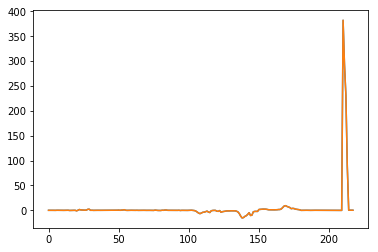

In [35]:
plt.plot(a)
plt.plot(outp.numpy()[0])

In [22]:
in_vec_trans = input_transform.transform(in_vec).astype(np.float32); in_vec_trans

array([[ 6.59148354e-05,  7.40151736e-05,  1.34432150e-04,
         1.15128438e-04,  1.39805969e-04,  1.37500640e-04,
         1.03682512e-04,  8.48544078e-05,  2.80214335e-05,
        -1.27765321e-04, -5.23313880e-04, -1.74274924e-03,
        -4.49004443e-03, -9.72546078e-03, -1.98827777e-02,
        -3.74800526e-02, -6.79020584e-02, -1.16899364e-01,
        -1.73153460e-01, -2.49714956e-01, -3.93160552e-01,
        -6.25455081e-01, -8.80603313e-01, -9.90112007e-01,
        -1.04529274e+00, -1.10669434e+00, -1.13370800e+00,
        -1.17053473e+00, -1.22552884e+00, -1.33292460e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -6.22926528e-25,
        -8.70422525e-07, -3.04611539e-03, -3.43990028e-02,
        -8.74299631e-02, -1.53205663e-01, -2.77719915e-0

## What about the noadiab version

In [4]:
cam_ds = xr.open_mfdataset(CAMDIR+ 'debug.cam2.h1.*.nc', decode_times=False, concat_dim='time')


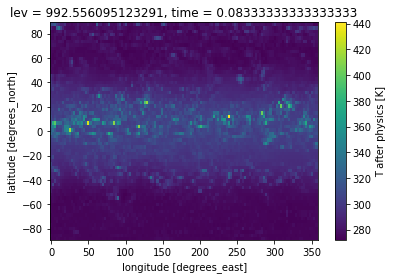

In [5]:
cam_ds.TAP.isel(time=-1, lev=-1).plot()

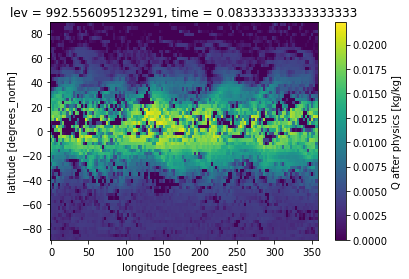

In [7]:
cam_ds.QAP.isel(time=-1, lev=-1).plot()

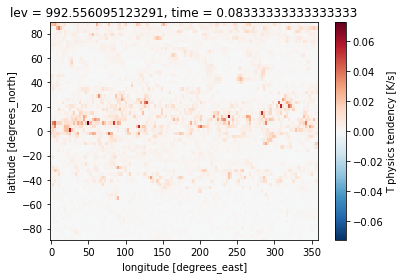

In [8]:
cam_ds.TPHYSTND.isel(time=-1, lev=-1).plot()

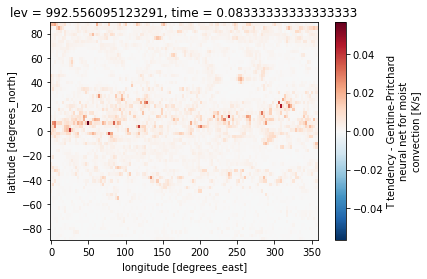

In [9]:
cam_ds.NNDT.isel(time=-1, lev=-1).plot()

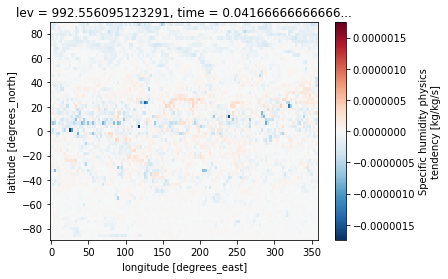

In [10]:
cam_ds.PHQ.isel(time=2, lev=-1).plot()

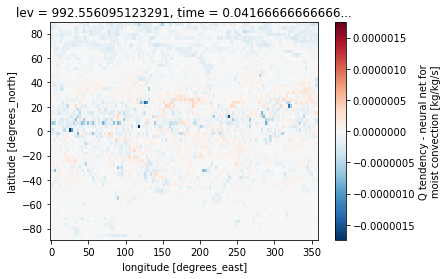

In [28]:
cam_ds.NNDQ.isel(time=2, lev=-1).plot()

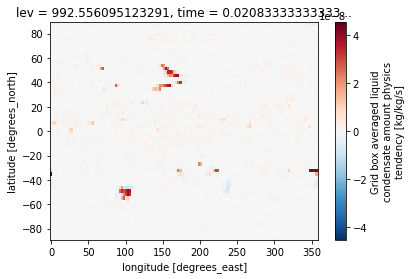

In [12]:
cam_ds.PHCLDLIQ.isel(time=1, lev=-1).plot()

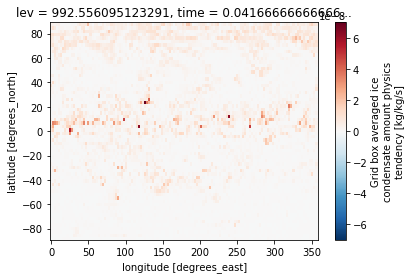

In [13]:
cam_ds.PHCLDICE.isel(time=2, lev=-1).plot()

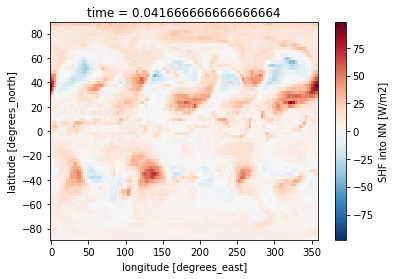

In [14]:
cam_ds.NNSHF.isel(time=2).plot()

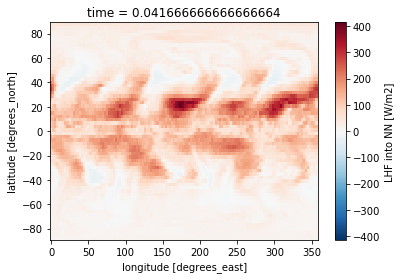

In [15]:
cam_ds.NNLHF.isel(time=2).plot()

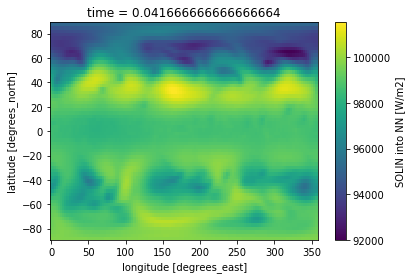

In [16]:
cam_ds.NNPS.isel(time=2).plot()

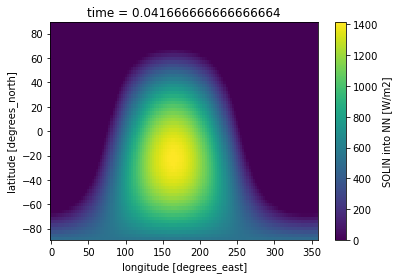

In [17]:
cam_ds.NNSOLIN.isel(time=2).plot()

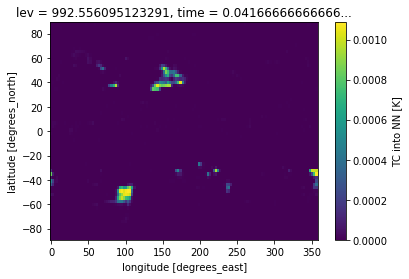

In [18]:
cam_ds.NNQCBP.isel(time=2, lev=-1).plot()

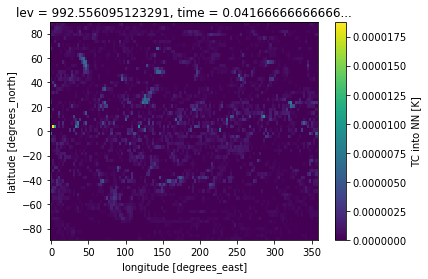

In [19]:
cam_ds.NNQIBP.isel(time=2, lev=-1).plot()

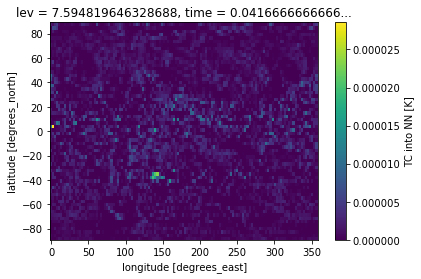

In [20]:
cam_ds.NNQIBP.isel(time=2, lev=1).plot()

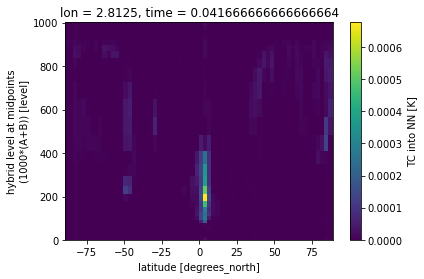

In [21]:
cam_ds.NNQIBP.isel(time=2, lon=1).plot()

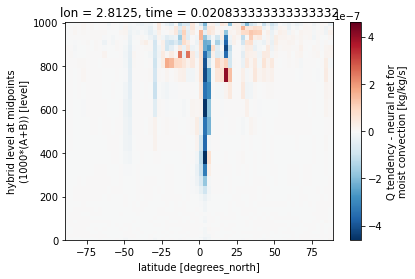

In [22]:
cam_ds.NNDQI.isel(time=1, lon=1).plot()

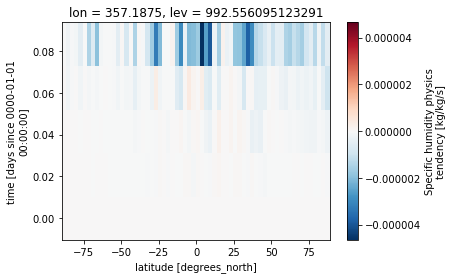

In [23]:
cam_ds.PHQ.isel(lev=-1, lon=-1).plot()

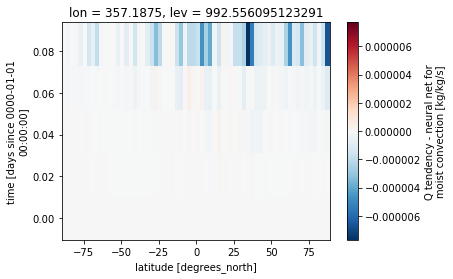

In [24]:
cam_ds.NNDQ.isel(lev=-1, lon=-1).plot()

## Try a Jacobian analysis

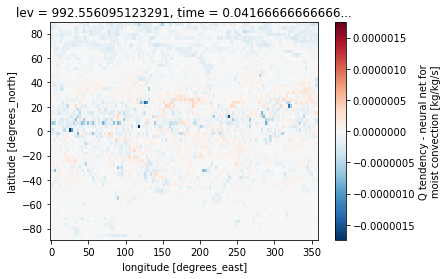

In [39]:
# Pick a point where in the second time step we are having issues.
cam_ds.NNDQ.isel(time=2, lev=-1).plot()

In [7]:
np.argmin(cam_ds.NNDQ.isel(time=2, lev=-1).min('lon').values), \
np.argmin(cam_ds.NNDQ.isel(time=2, lev=-1).min('lat').values)

(33, 42)

In [8]:
cam_ds.lat[33], cam_ds.lon[42]

(<xarray.DataArray 'lat' ()>
 array(4.185921)
 Coordinates:
     lat      float64 4.186
 Attributes:
     long_name:  latitude
     units:      degrees_north, <xarray.DataArray 'lon' ()>
 array(118.125)
 Coordinates:
     lon      float64 118.1
 Attributes:
     long_name:  longitude
     units:      degrees_east)

In [9]:
ilat = 33; ilon = 42

In [10]:
in_vec = np.concatenate([
    cam_ds.NNQBP.isel(time=2, lat=ilat, lon=ilon).values,
    cam_ds.NNQCBP.isel(time=2, lat=ilat, lon=ilon).values,
    cam_ds.NNQIBP.isel(time=2, lat=ilat, lon=ilon).values,
    cam_ds.NNTBP.isel(time=2, lat=ilat, lon=ilon).values,
    cam_ds.NNVBP.isel(time=2, lat=ilat, lon=ilon).values,
    cam_ds.NNPS.isel(time=2, lat=ilat, lon=ilon).values[None],
    cam_ds.NNSOLIN.isel(time=2, lat=ilat, lon=ilon).values[None],
    cam_ds.NNSHF.isel(time=2, lat=ilat, lon=ilon).values[None],
    cam_ds.NNLHF.isel(time=2, lat=ilat, lon=ilon).values[None],
])[None, :]

In [11]:
in_vec.shape

(1, 154)

In [12]:
model = fc_model(154, 218, [256,256,256,256,256,256,256], 'LeakyReLU')

In [13]:
model.load_weights('/home1/05488/tg847872/saved_models/004_8col_weak_noadiab//weights.h5')

In [14]:
inputs = ['QBP', 'QCBP', 'QIBP', 'TBP', 'VBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX']

In [15]:
input_transform = InputNormalizer(
    xr.open_dataset('/home1/05488/tg847872/saved_models/001_norm.nc'),
    inputs,
    'mean', 'std_by_var'
)

In [16]:
in_vec_norm = input_transform.transform(in_vec)

In [17]:
from cbrain.model_diagnostics import *

In [19]:
J = get_jacobian(in_vec_norm[0], model)

/home1/05488/tg847872/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [21]:
J.std()

122.178734

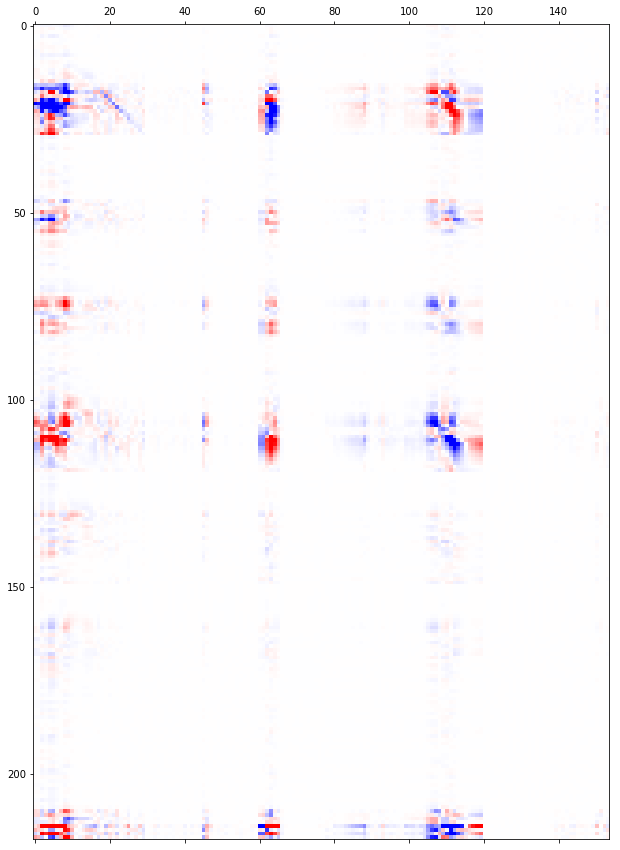

In [33]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(J, cmap='bwr', vmin=-1000, vmax=1000)